# Swelling_tablet_fronts_D_k_from_MRI_T2_or_img
Tool for characterizing the swelling of tablets immersed in a solution. Creates time plots and calculates eroding front's diffusion rate D and the rate of the swelling k from time series of either T<sub>2</sub>-maps or (properly contrasted, e.g. T<sub>2</sub>-weighted) MRI images in FDF (file format native for Agilent MRI scanners) or Text Image format. This software is suitable for swelling matrix tablets forming a membrane-like structure in contact with the solution in which they are immersed.

## 1 Introduction

Tablets are widely used means of administering drugs. Aside from the importance of the therapeutic agent, the excipients can also affect the efficacy of the formulation. Gel-forming hydrophilic matrix tablets exhibit sustained release of drug, nevertheless, their experimental characterization is a complex task. Measuring the rate of drug released over a period of time does not reveal enough information concerning the underlying behaviour of the polymer or release mechanisms. More insight can be obtained from imaging experiments, in which the tablet behaviour is observed directly. Magnetic resonance imaging (MRI) was proved essential method for such studies as MRI images and T<sub>2</sub>-maps can provide comprehensive information about dimensional changes and properties alterations in tablets during hydration.

Outer surface of hydrophilic matrix tablets swells in contact with water by polymer hydration and chain relaxation, forming a hydrogel layer around the dry core. The interface between the dry tablet interior and the swollen polymer layer is known as the swelling front, while the interface between the hydrogel and the bulk water is called the eroding front. The properties of various layers formed within matrix tablets during hydration are important in controlling release of the drug and thus, their characteristics are of interest. Some tablets immersed in certain solutions can form membrane-like structures on the eroding front. Here, Carbopol tablets immersed in nonionic surfactant solution will serve as an example. The membrane-like structure has low water content and relatively short transverse (or spin-spin) relaxation time T<sub>2</sub>, so it appears dark on T<sub>2</sub>-weighted MRI images (and image representations of T<sub>2</sub>-maps).

The presented software will track the position of the membrane-like structure on the eroding front in selected region of interest (ROI) through the time series of either MRI images or T<sub>2</sub>-maps, calculate average swelling profiles and approximate the eroding front's diffusion rate D and the rate of the swelling k.


## 2 The sample data
### *2.1 Carbopol tablets and nonionic surfactant solution*
Pre-formed 500 mg circular flat-faced Carbopol tablets with diameter of 15 mm were placed in a vacuum chamber for 20 h to remove water present in the powder. Subsequently the tablets were compressed by the pressure of 2 tons for 5 minutes to form the final tablets.
3% solution of nonionic surfactant (Brij 58) was prepared by dissolving the surfactant in deionized water.
### *2.2 MRI experiments*
Magnetic resonance imaging experiments were performed at 37°C on a 9.4 T horizontal bore Agilent MRI scanner using a 40 mm diameter millipede coil for transmission and reception. To observe changes in Carbopol tablets during swelling, the MRI experiments were performed at different times after placing the tablet in a container filled with the surfactant solution. A spin-echo Multi-Echo Multi-Slice (MEMS) imaging sequence was used to obtain 128 x 128 pixel  (40 x 40 mm) images with 16 echo time (TE) values set in a range from 10 ms to 160 ms. T<sub>2</sub>-maps were calculated from the acquired images.

## 3 The software
### *3.1 The input parameters*
1. T<sub>2</sub> maps (or MRI images) location folder: **maps_path** (string variable, e.g. "D:/MRI_FDF" or just "MRI_FDF" if located in one folder with the script or the executable file)
2. type of image file: **file_type** (0 - Text Image, 1 - FDF; applicable to the main script version, not vB nor EXE)
3. size of a pixel in mm: **pixel_size** (floating point number, e.g. 0.3125)
4. region of interest: **roi** (tuple with ROI corners coordinates: ((x1,y1),(x2,y2)), e.g. ((66, 55), (69, 76)))
5. averaging direction: **aver_axis** (0 - average rows, 1 - average collumns of ROI)
6. range of data for D function fitting: **fit_range_D** (tuple: (start_point, stop_point), e.g. (0, 13))
7. range of data for k function fitting: **fit_range_k** (tuple: (start_point, stop_point), e.g. (0, 16))
8. output folder: **out_folder** (string variable, e.g. "D_results")

### *3.2 How the code works step by step*
#### *3.2.1 Importing the necessary libraries*

In [1]:
import os
import shutil
import itk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from scipy.optimize import curve_fit

#### *3.2.2 Introducing input parameters*

In [2]:
maps_path = "MRI_FDF"             # Path to T2 maps (or MRI images): maps_path [str]
file_type = 1                     # Type of image file: file_type [bool: 0 - Text Image, 1 - FDF]
pixel_size = 0.3125               # Size of a pixel in mm: pixel_size [float]
roi = ((66, 55), (69, 76))        # Region of interest: roi [tuple, ((x1,y2),(x2,y1))]
out_folder = "D_results"          # Output folder: out_folder [str]
aver_axis = 1                     # Averaging direction: aver_axis (0 - average rows, 1 - average collumns of ROI)
fit_range_D = (0, 13)             # Range of data for D function fitting: fit_range_D [tuple (start_point, stop_point)]
fit_range_k = (0, 16)             # Range of data for k function fitting: fit_range_k [tuple (start_point, stop_point)]

#### *3.2.3 Preparing the output folder*
Please be advised that the program will remove old output folder with previous results upon start of a new run.

In [3]:
shutil.rmtree(out_folder, ignore_errors=True)            # removing residual output folder with content
os.makedirs(out_folder)                                  # creating new output folder

#### *3.2.4 Importing images, extracting ROIs and creating average profiles*

After the import, the program overlays the given ROI's shape on the imported images for visual veryfication and saves the figures in the output folder. The ROI should not comprise the dry core of the tablet. Subsequently, the ROIs are extracted from the images. Average profiles are calculated by averaging lines or columns of given ROI, accordingly to the defined averaging direction (aver_axis parameter). The time series of the average profiles constitutes a dataframe.

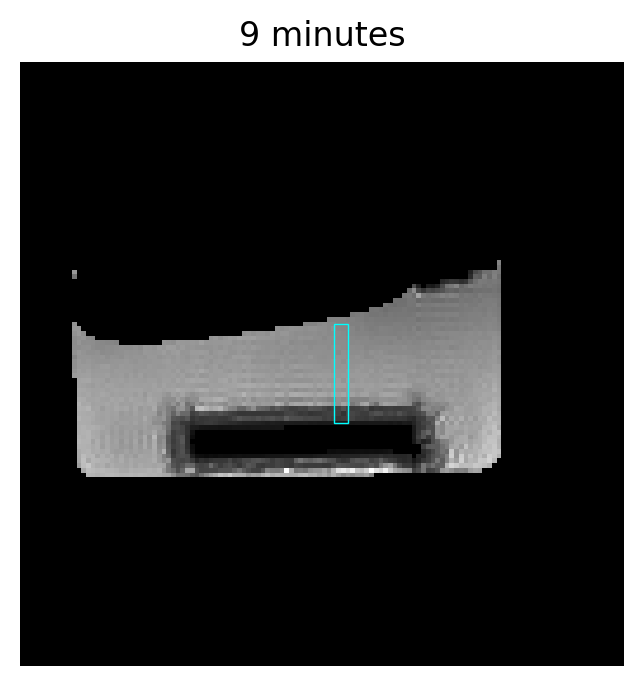

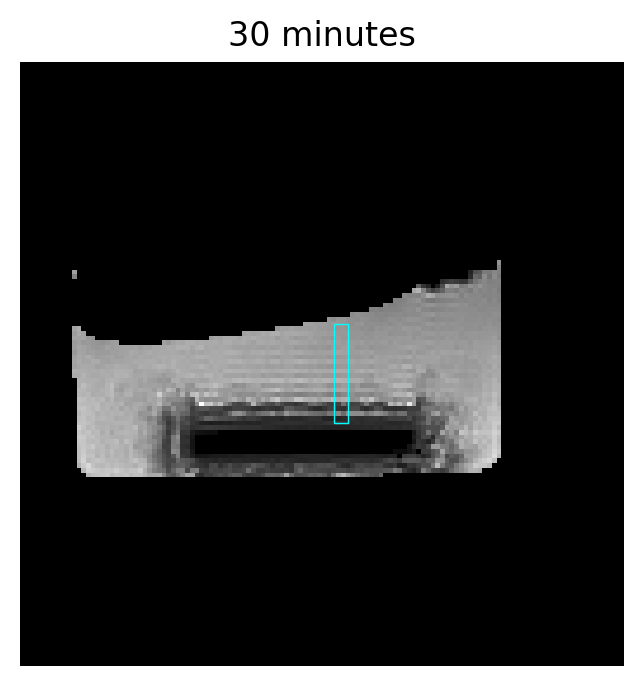

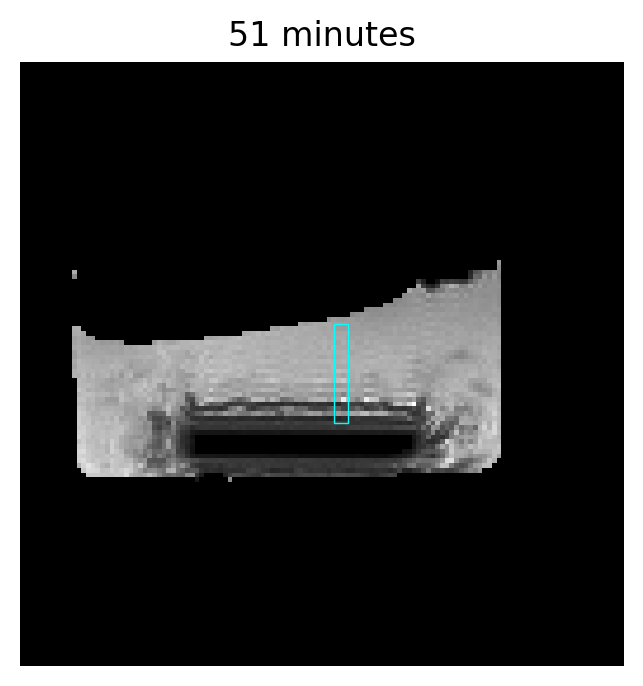

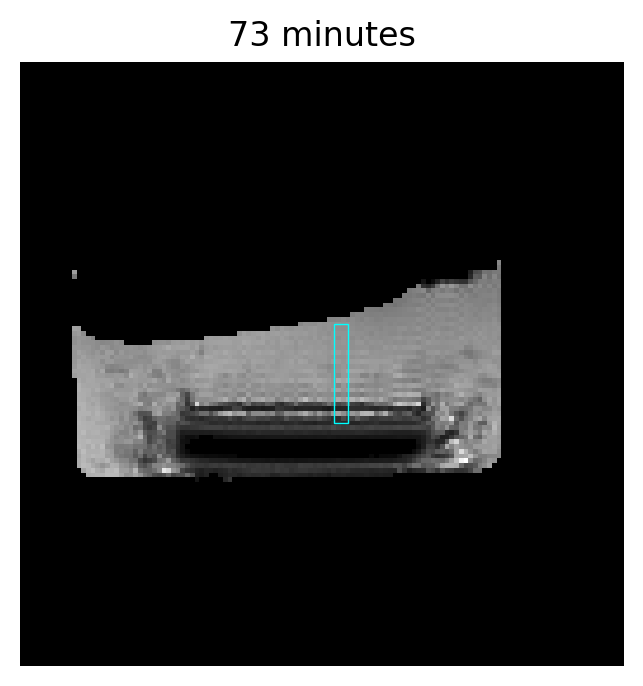

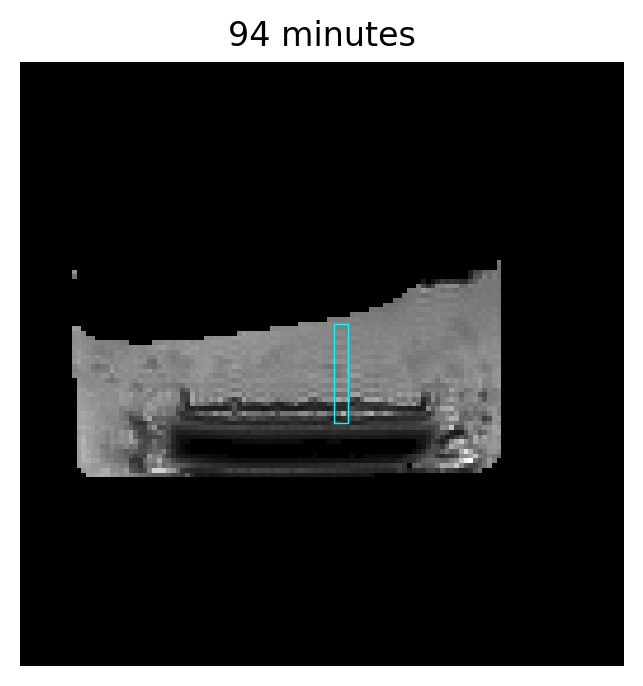

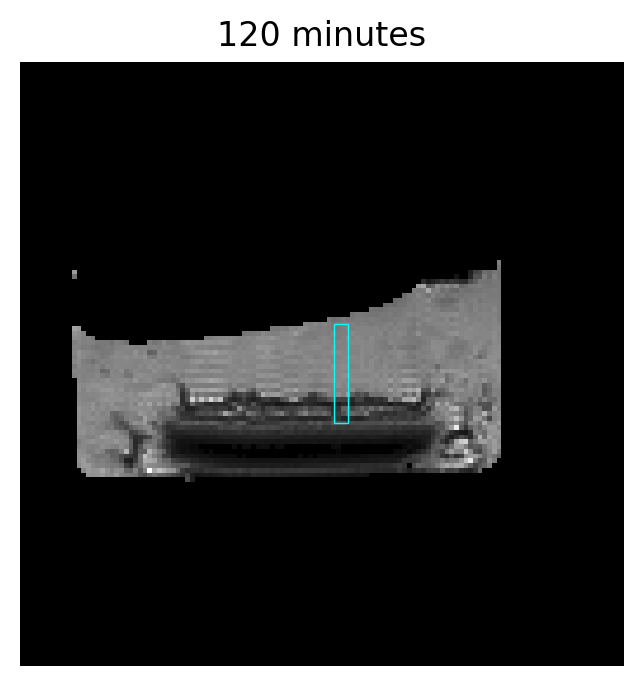

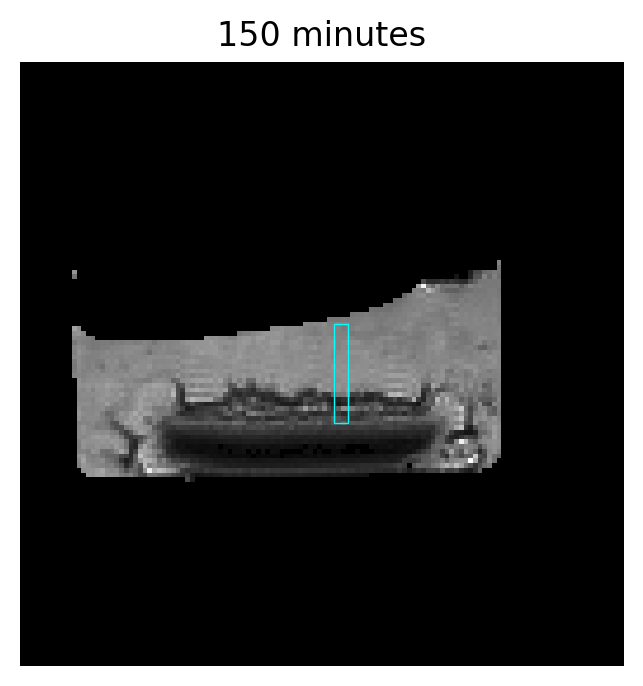

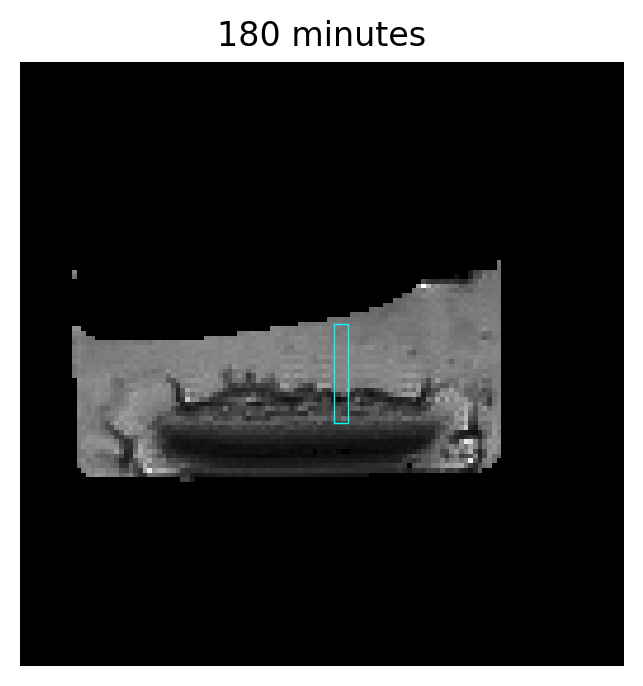

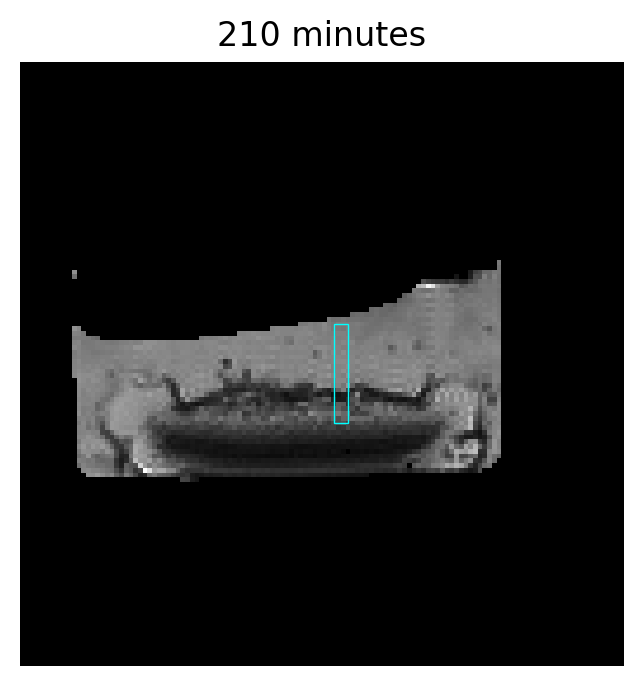

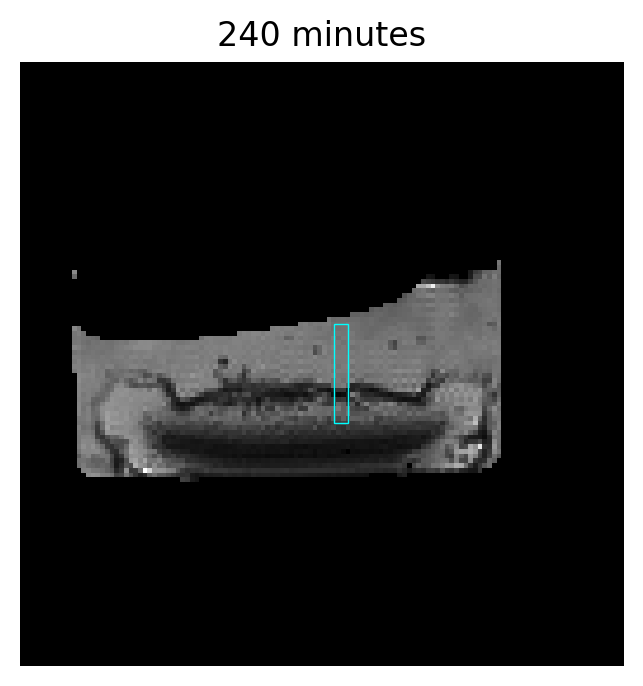

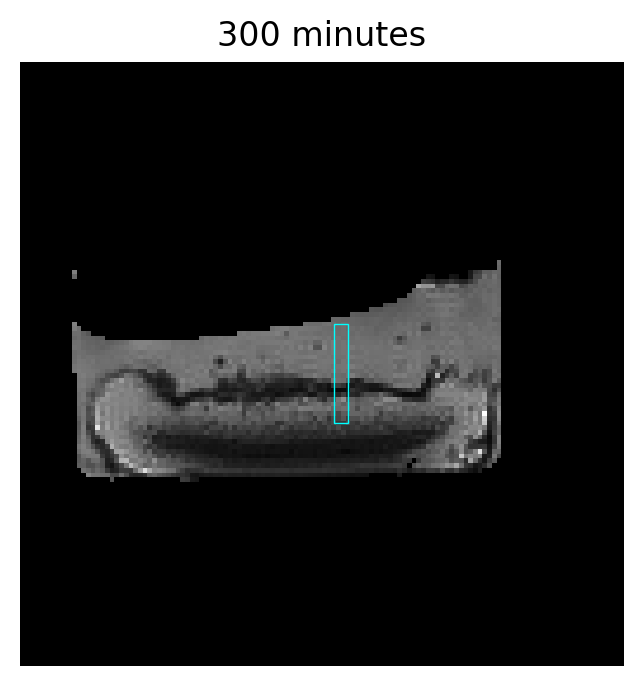

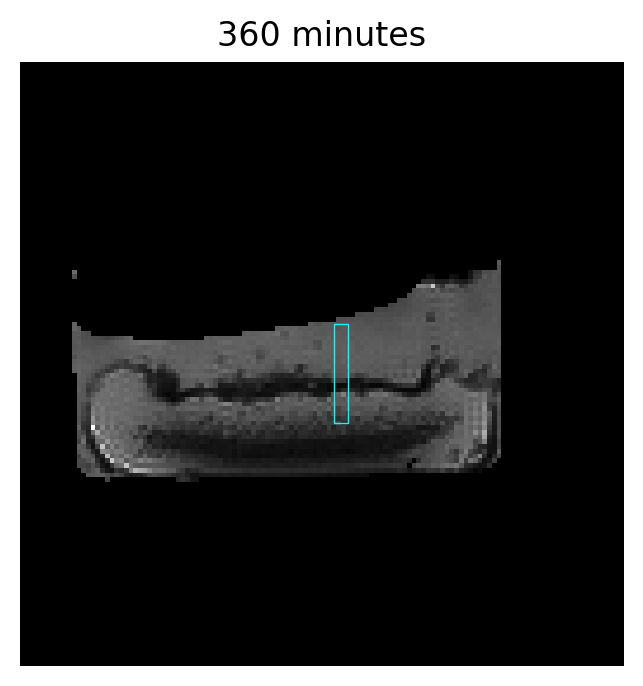

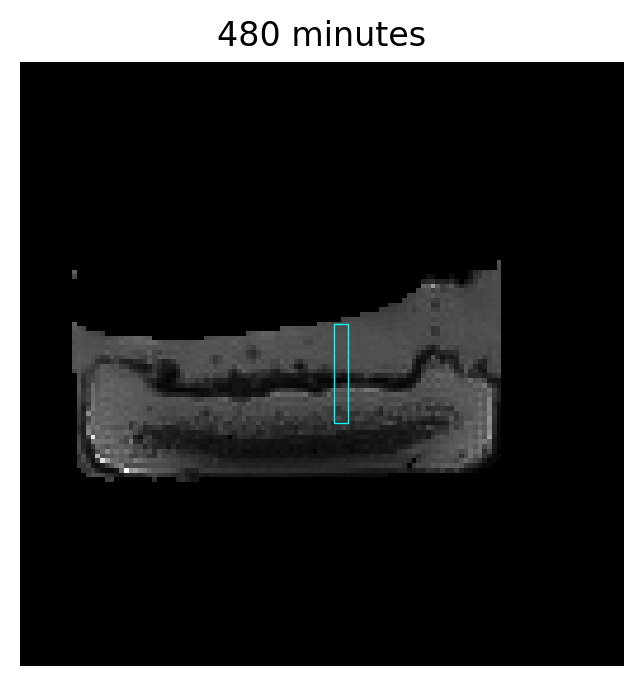

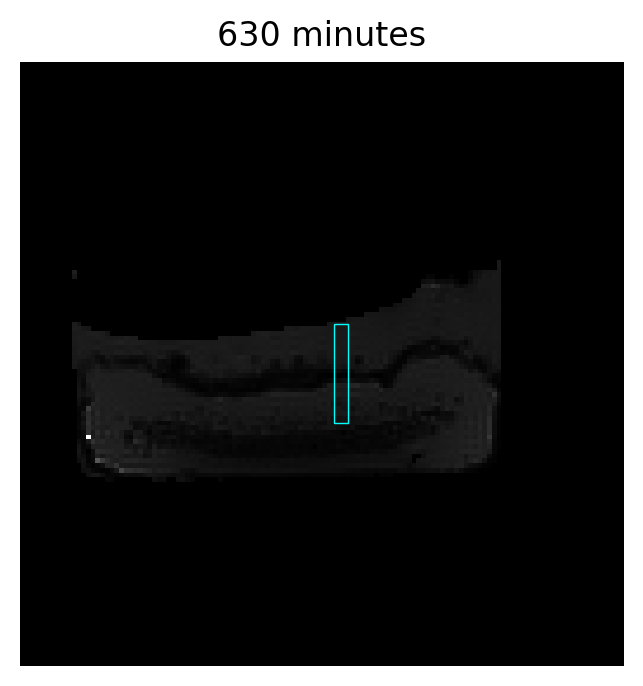

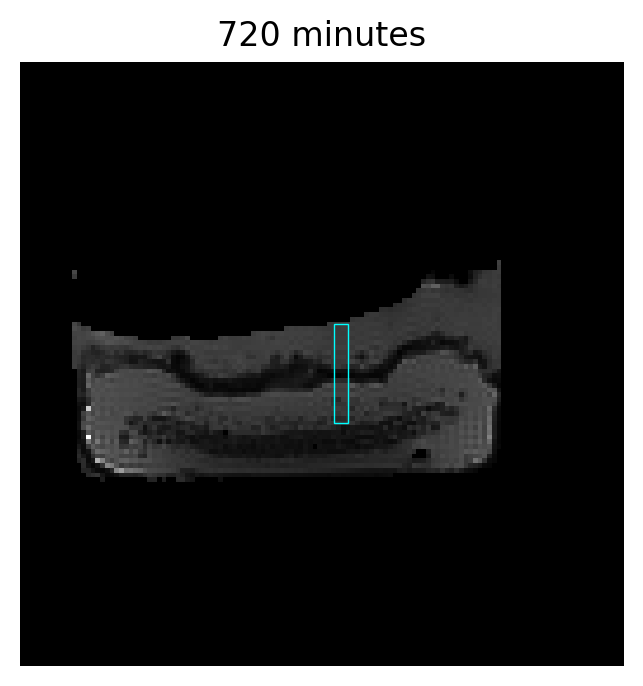

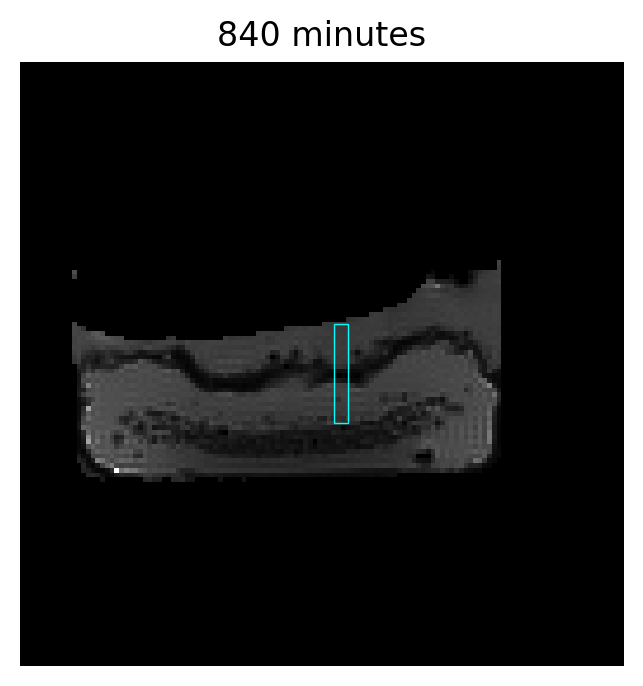

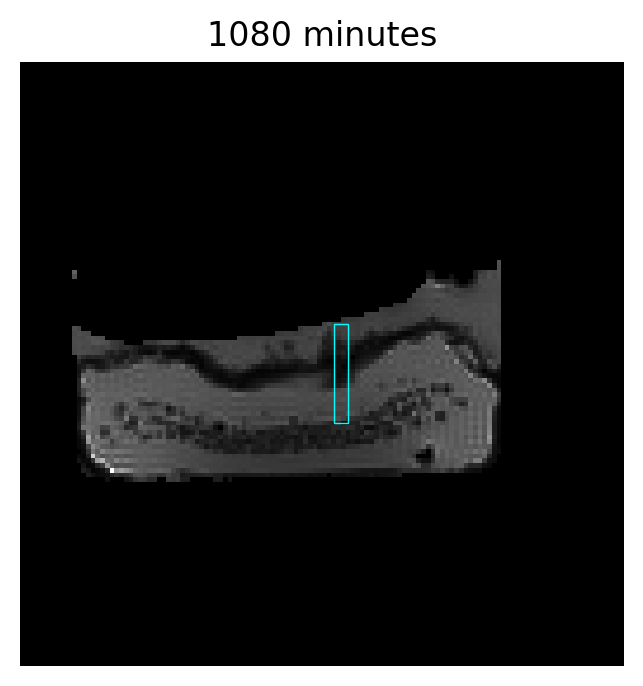

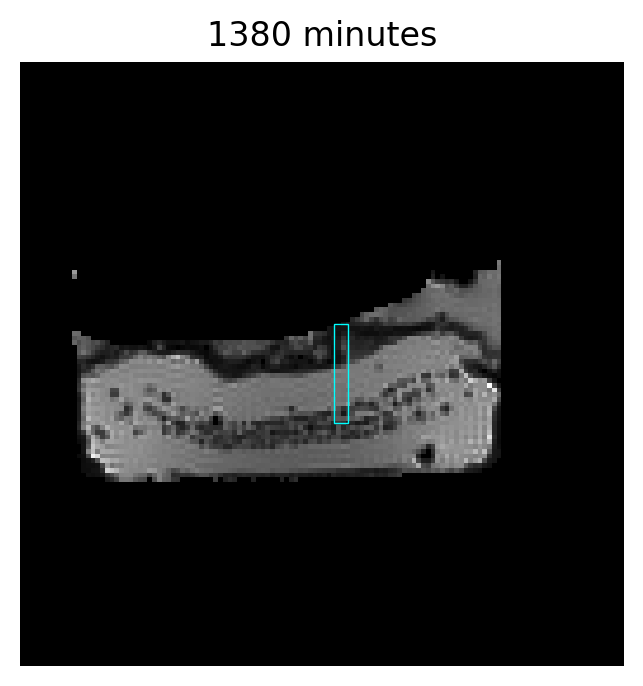

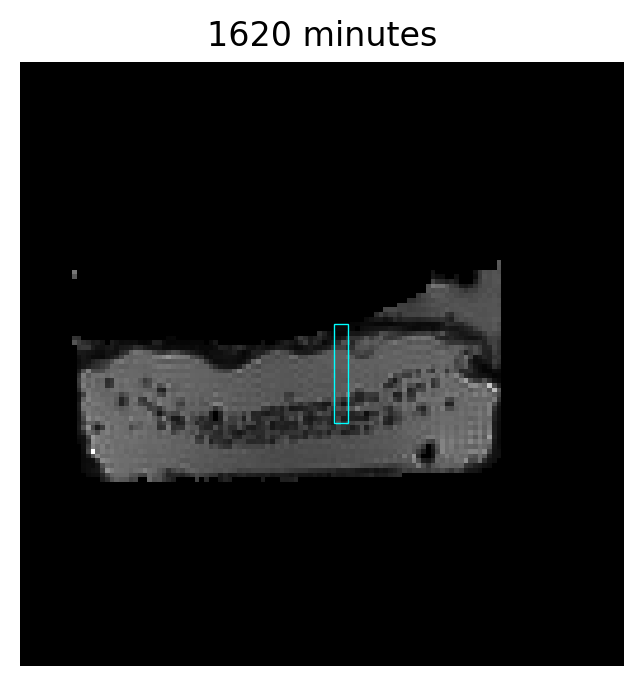

In [4]:
files = os.listdir(maps_path)                            # list of T2 map (MRI images) files
df = pd.DataFrame()                                      # dataframe for the average profiles

for file in files:
            
    # import images/maps as numpy arrays
    if file_type:
        # importing FDFs 
        imageio = itk.FDFImageIO.New()
        locals()[os.path.splitext(file)[0]] = np.array(itk.imread(f'{maps_path}/{file}', imageio=imageio))
            
    else:
        # importing text images
        locals()[os.path.splitext(file)[0]] = np.loadtxt(f'{maps_path}/{file}', dtype=float)
        
    # T2 maps and ROI: visual veryfication
    img = locals()[os.path.splitext(file)[0]]
    img = img/(img.max()/255.0)
    plt.rcParams['figure.dpi'] = 200
    figure, image = plt.subplots()
    image.imshow(img, cmap=plt.get_cmap('gray'))
    w = roi[1][0] - roi[0][0]
    h = roi[1][1] - roi[0][1]
    roi_rect = Rectangle(roi[0], w, h, linewidth=0.5, edgecolor='cyan', facecolor='none')
    image.add_patch(roi_rect)
    plt.axis('off')
    plt.title(f'{int(os.path.splitext(file)[0])} minutes')
    # saving T2 map with ROI as png image
    plt.savefig(f'{out_folder}/{os.path.splitext(file)[0]}.png', bbox_inches='tight')
    # showing T2 map with ROI
    plt.show()
        
    # extracting ROIs from images
    locals()[os.path.splitext(file)[0]] = locals()[os.path.splitext(file)[0]][roi[0][1] : roi[1][1]+1, \
                                                                                  roi[0][0] : roi[1][0]+1]
        
    # creating average profiles
    locals()[os.path.splitext(file)[0]] = np.mean(locals()[os.path.splitext(file)[0]], axis=aver_axis)
    
    # filling dataframe with the profiles as columns (column names are time in minutes)
    df[int(os.path.splitext(file)[0])] = locals()[os.path.splitext(file)[0]]
    
# dataframe indexes as distance in mm
df['distances'] = (pd.Series(range(len(df.index)-1, -1, -1))) * pixel_size
df = df.set_index(['distances'])

#### *3.2.5 Finding swelling tablet front's location*

The program finds minimal value in each average profile and saves its location as a data point representing location of the eroding front. The data points are saved in the output folder as CSV file. The time series of the average profiles is ploted with overlayed locations. The figure is also saved in the output folder. 

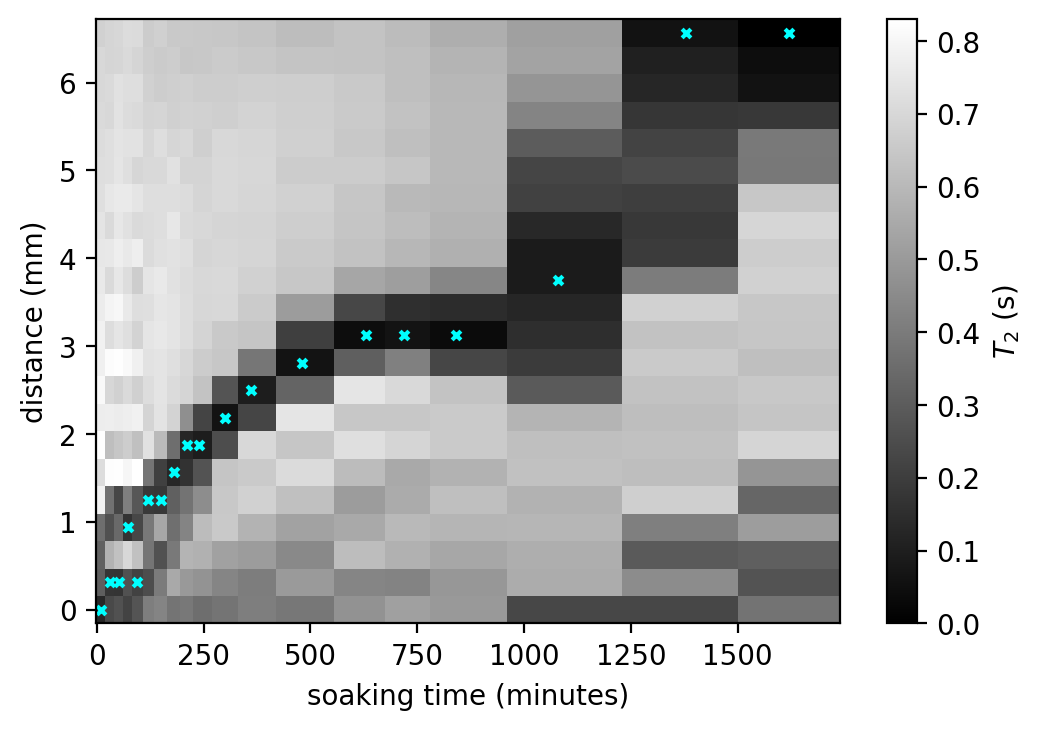

In [5]:
# find min T2 (tablet front location) in every profile
minT2distances = df.idxmin()
minT2distances = minT2distances.rename({'0': 'distance_mm'})
# save datapoints as csv
minT2distances.to_csv(f'{out_folder}/datapoints.csv', index_label='time_minutes', header=['distance_mm'])
    
# the T2-profile time dependence with overlayed scatter plot
# (1) colormesh
x = df.columns
y = df.index
z = np.array(df)
x, y = np.meshgrid(x, y)
fig, ax = plt.subplots()
plt.grid(False)
ax.pcolormesh(x.astype(float), y, z, cmap = 'gray')
plt.colorbar(ax.pcolormesh(x.astype(float), y, z, cmap = 'gray'), label = r'$T_{2}$'+' (s)')
# (2) scatter plot
plt.scatter(minT2distances.index, minT2distances, marker='x', color='cyan', s=10)
plt.xlabel('soaking time (minutes)')
plt.ylabel('distance (mm)')
plt.savefig(f'{out_folder}/plot1.png', bbox_inches='tight')
plt.show()

#### *3.2.6 Diffusion coefficient D approximation*

Based on the eroding front's relocation in time, diffusion coefficient D is calculated using the below equation (one-dimensional random walk or diffusion over distance theory):

<x<sup>2</sup>> = 2 D t

<x<sup>2</sup>> - mean-square displacement (cm<sup>2</sup>), 
D - diffusion coefficient (cm<sup>2</sup> s<sup>-1</sup>), 
t - time (s). 

The data used for the calculation is within the fit_range_D (recomended range: from t-min to the point before the start of the first plateau). The plot of the data with the fitted curve is saved in the output folder.

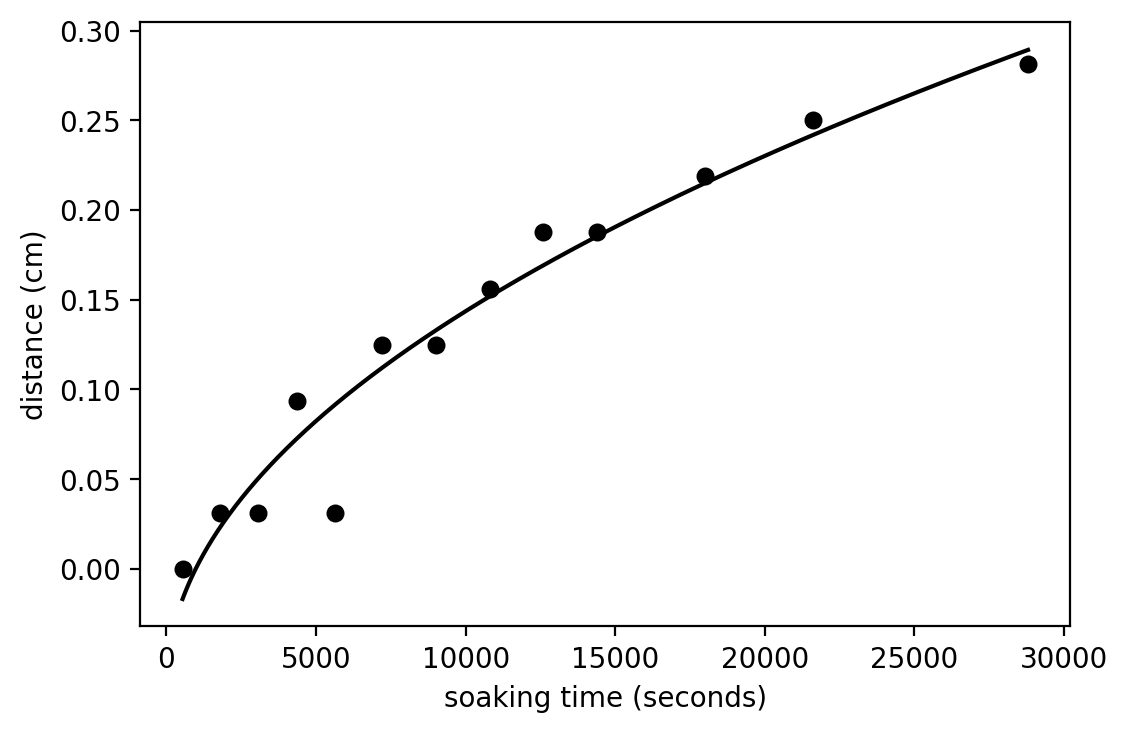

In [6]:
# data for function fitting (recomended range: from t-min to the point before the start of the first plateau)
t = list(minT2distances.index[fit_range_D[0]:fit_range_D[1]] * 60)             # t * 60 (min -> sec)
dist = list(minT2distances[fit_range_D[0]:fit_range_D[1]] / 10)                # dist / 10 (mm -> cm)
    
# fitting function definition
def Dfunct(x, D, c):
    # diffusion coefficient D approximation: dist = (2Dt)^(1/2) ; x is time
    return np.sqrt(2*D*x) + c
    
# fit curve
params, covariance = curve_fit(Dfunct, t, dist, bounds=((0,-np.inf), np.inf))
D, c = params
# get the standard deviations of the parameters
st_devs = np.sqrt(np.diag(covariance))
D_st_dev, c_st_dev = st_devs
    
# plot of fitted curve
x_curve = range(min(t), max(t), 1)
y_curve = Dfunct(x_curve, D, c)
plt.plot(x_curve, y_curve, color='black')
plt.scatter(t, dist, color='black', s=30)
plt.xlabel('soaking time (seconds)')
plt.ylabel('distance (cm)')
plt.savefig(f'{out_folder}/plot2.png', bbox_inches='tight')
plt.show()

#### *3.2.7 Rate of the swelling k approximation*

Similarly, the rate constant of the swelling k is calculated based on the data within the fit_range_k (recomended range: from t-min to the end of the first plateau), using the equation below:

d = d<sub>max</sub> - c exp(-kt)

d - distance, d<sub>max</sub> - maximum distance at equilibrium, c - a constant, t - the immersion time, k - the rate
constant of the swelling.

The plot of the data with the fitted curve is saved in the output folder.

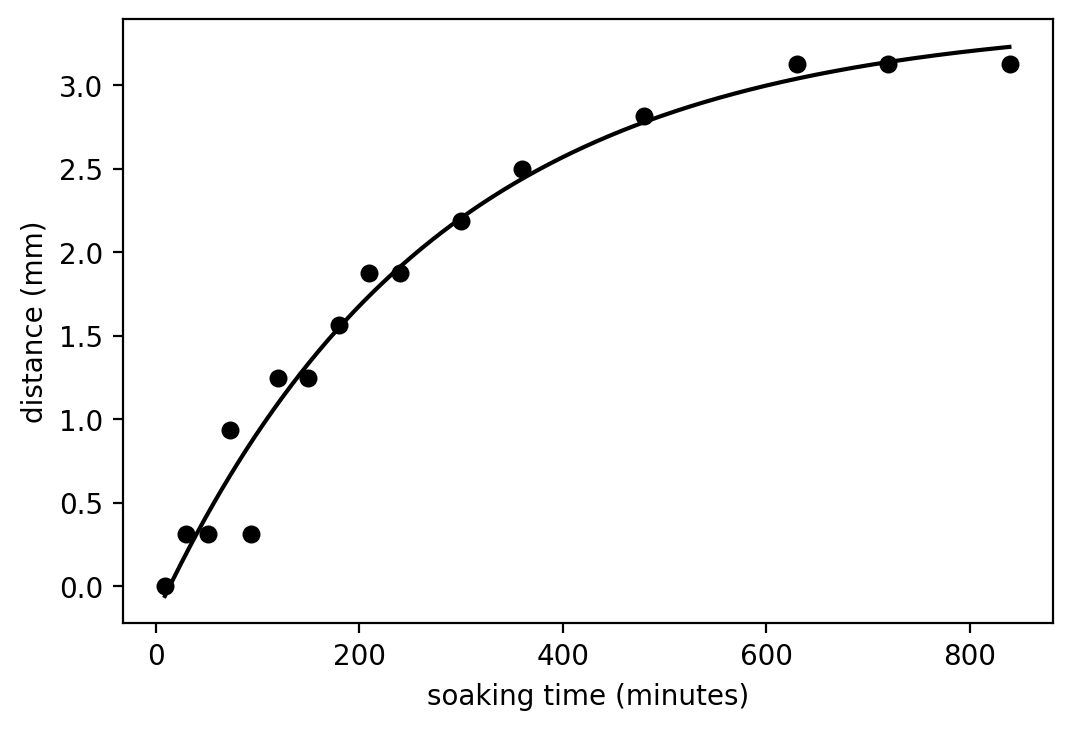

In [7]:
# data for 2nd function fitting (recomended range: from t-min to the end of the first plateau)
t = list(minT2distances.index[fit_range_k[0]:fit_range_k[1]])
dist = list(minT2distances[fit_range_k[0]:fit_range_k[1]])
    
# 2nd fitting function definition
def kfunct(x, max_dist, a, k):
    # rate of swelling k approximation: dist = max_dist - a * exp(-k * t) ; x is time
    return max_dist - a * (np.exp(-k * x))
    
# fit 2nd curve
params, covariance = curve_fit(kfunct, t, dist, p0 = (dist[-1], 3, 0.0036), bounds=((0,-np.infty, 0), np.inf))
max_dist, a, k  = params
st_devs = np.sqrt(np.diag(covariance))
max_dist_st_dev, a_st_dev, k_st_dev = st_devs
    
# plot of 2nd fitted curve
x_curve = range(min(t), max(t), 1)
y_curve = kfunct(x_curve, max_dist, a, k)
plt.plot(x_curve, y_curve, color='black')
plt.scatter(t, dist, color='black', s=30)
plt.xlabel('soaking time (minutes)')
plt.ylabel('distance (mm)')
plt.savefig(f'{out_folder}/plot3.png', bbox_inches='tight')
plt.show()

#### *3.2.8 Saving fitting results in text file*

All fitting results are saved in text file in the output folder.

In [8]:
with open(f'{out_folder}/fit_parameters.txt', 'w') as f:
    f.write('Fitting results for    <x> = (2Dt) ^ (1/2) + c \n\n')
    f.write(f'D = {D} '+u'\u00B1'+f' {D_st_dev} (cm2s-1) \n')
    f.write(f'c = {c} '+u'\u00B1'+f' {c_st_dev} (cm) \n\n')
    f.write('Fitting results for    dist = max_dist - a * exp(-k * t) \n\n')
    f.write(f'max_dist = {max_dist} '+u'\u00B1'+f' {max_dist_st_dev} (mm) \n')
    f.write(f'a = {a} '+u'\u00B1'+f' {a_st_dev} (mm) \n')
    f.write(f'k = {k} '+u'\u00B1'+f' {k_st_dev} (min-1)\n')

## 4 Results
### *4.1 List of files in the output folder*

After finishing the program run, the output folder contains all the generated figures and plots, data points as CSV file and fitting results as text file.

In [9]:
os.listdir(out_folder)

['0009.png',
 '0030.png',
 '0051.png',
 '0073.png',
 '0094.png',
 '0120.png',
 '0150.png',
 '0180.png',
 '0210.png',
 '0240.png',
 '0300.png',
 '0360.png',
 '0480.png',
 '0630.png',
 '0720.png',
 '0840.png',
 '1080.png',
 '1380.png',
 '1620.png',
 'datapoints.csv',
 'fit_parameters.txt',
 'plot1.png',
 'plot2.png',
 'plot3.png']

It is worth notting that the plot of the location of the eroding front in time resembles the shape of the plot of normalised mass uptake in time for hydrating PVA–PVP tablets (based on average water contents derived from the MRI images) presented in the literature (https://doi.org/10.1002/pi.2860).

### *4.2 The fitting results*

The fitting results for the sample data (saved as fit_parameters.txt) are presented below.

In [10]:
with open(f'{out_folder}/fit_parameters.txt') as results:
    print(results.read())

Fitting results for    <x> = (2Dt) ^ (1/2) + c 

D = 2.181722171141391e-06 ± 3.185633353583222e-07 (cm2s-1) 
c = -0.06526789218721617 ± 0.015675660549420004 (cm) 

Fitting results for    dist = max_dist - a * exp(-k * t) 

max_dist = 3.3945919600439436 ± 0.1893344984999005 (mm) 
a = 3.56749966139804 ± 0.18001323207634468 (mm) 
k = 0.0036591849400793523 ± 0.0005355667693002307 (min-1)



The D value obtained is within the range expected for the macromolecule in water. The k value also lies within expectations, based on the literature describing swelling of high-amylose starch tablets (https://doi.org/10.1021/bm015621e). The above results demonstrate that the presented software can be a valuable tool for characterizing swelling matrix tablets forming a membrane-like structure in contact with the solution in which they are immersed.


## 5 D_k_from_T2maps_vB and the EXE file

D_k_from_T2maps_vB_win10.exe (compiled for Windows 10) is a version of the program created for non-coders. It can be used simply by double-clicking, taking input parameters from an input file (sample input file content is presented below).

In [11]:
with open('INPUT-D_k_from_T2maps_vB.txt') as input_file:
    print(input_file.read())

""" input file for D_from_T2maps_vB """

maps_path = "MRI_TXTimages"                      # Path to T2 maps (or MRI images)[str]
pixel_size = 0.3125                              # Size of a pixel in mm [float]
roi = ((66, 55), (69, 76))                       # Region of interest [tuple, ((x1,y2),(x2,y1))]
out_folder = "D_results"                         # Output folder [str]
aver_axis = 1                                    # averaging direction (0 - average rows, 1 - average collumns of ROI)
fit_range_D = (0, 13)                            # Range of data for D function fitting: fit_range_D [tuple (start_point, stop_point)]
fit_range_k = (0, 16)                            # Range of data for k function fitting: fit_range_k [tuple (start_point, stop_point)]



D_k_from_T2maps_vB_win10.exe only accepts Text Images as an input (I had troubles compyling a script utilizing itk - python library enabling FDF import). HINT: Most of image files can be converted to Text Image format using ImageJ (https://imagej.nih.gov/ij/download.html). To import FDF files by ImageJ you'll need Multi FDF Opener plugin (https://imagej.nih.gov/ij/plugins/multi-opener.html).

Python script used for creating the EXE file: D_k_from_T2maps_vB.py.

## 6 About the author

Beata Wereszczyńska, PhD

e-mail: b.e.wereszczynska@gmail.com

GitHub: https://github.com/BeataWereszczynska

ORCID: https://orcid.org/0000-0003-3013-212X

ResearchGate: https://www.researchgate.net/profile/Beata-Wereszczynska

LinkedIn: https://www.linkedin.com/in/beata-wereszczynska/

## 7 License

The software is licensed under the MIT license. The non-software content of this project is licensed under the Creative Commons Attribution 4.0 International license. See the LICENSE file for license rights and limitations.